# Optimizing AI Trading Algorithms - Final Project

In this project we focus on optimizing various aspects of a machine learning model for predicting stock price movements. This will provide you with an opportunity to integrate and practice the concepts covered in the course, such as data pre-processing, hyperparameter tuning, detecting and addressing over-/under-fitting, regularization techniques, model evaluation, and drift detection techniques.


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

## 1. Data Acquisition, Exploration, Cleaning and Preprocessing


It is widely believed that the Utilities, Consumer Staples and Healthcare sectors are relatively more resilient to recessions and many stock market investors flock to these sectors in times of uncertainty. In this project, we will use daily OHLCV data for the [SPDR Healthcase Sector ETF](https://www.sectorspdrs.com/mainfund/XLV), a market volatility index, as well as monthly [Google search trends data](https://trends.google.com/trends/explore?date=all&geo=US&q=recession) for the word "recession" in the United States to try and predict whether the price of the Health Care Select Sector SPDR Fund [(NYSEARCA: XLV)
](https://finance.yahoo.com/quote/XLV) is going to increase or decrease over the next 5 trading days.


In [2]:
ohlcv_data = yf.download("XLV", start="2004-01-01", end="2024-03-31", interval="1d")
data = ohlcv_data.copy()

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5094 entries, 2004-01-02 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5094 non-null   float64
 1   High       5094 non-null   float64
 2   Low        5094 non-null   float64
 3   Close      5094 non-null   float64
 4   Adj Close  5094 non-null   float64
 5   Volume     5094 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 278.6 KB


In [4]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5.094000e+03
mean,65.342311,65.730397,64.924197,65.349097,58.242299,7.228951e+06
std,36.695351,36.915853,36.477869,36.712468,37.932219,5.445803e+06
min,22.010000,22.290001,21.629999,21.879999,16.812471,5.870000e+04
25%,31.990000,32.132501,31.812500,31.990000,24.508556,3.790550e+06
50%,57.100000,57.400000,56.680000,57.010000,48.387003,6.582850e+06
75%,90.657503,91.077497,89.927500,90.557499,82.941313,9.559550e+06
max,147.919998,148.270004,147.679993,147.860001,147.729996,6.647020e+07


In [5]:
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-22,145.850006,146.220001,145.259995,145.440002,145.440002,5537200
2024-03-25,145.710007,145.860001,145.009995,145.240005,145.240005,5253000
2024-03-26,145.529999,145.940002,145.139999,145.770004,145.770004,6942400
2024-03-27,147.009995,147.710007,146.619995,147.710007,147.710007,8797400
2024-03-28,147.919998,148.229996,147.679993,147.729996,147.729996,8090200


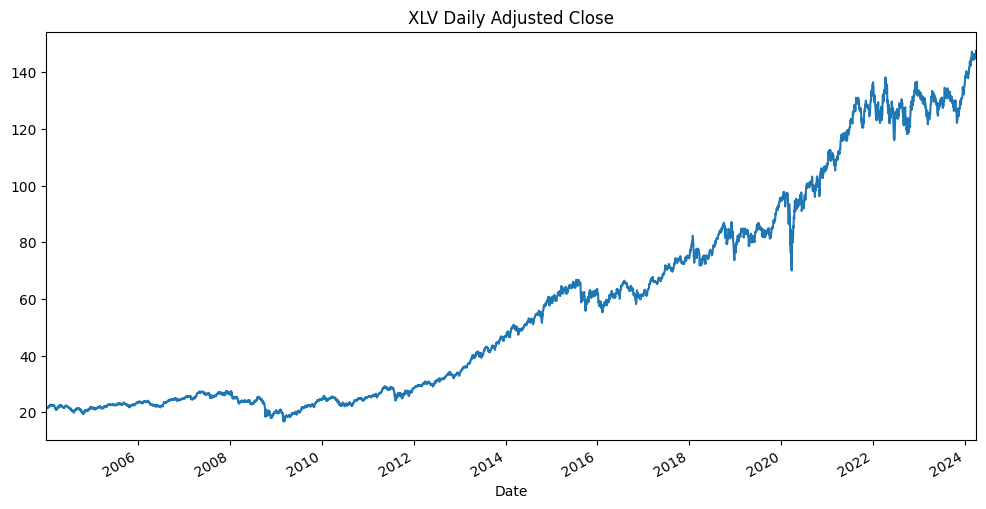

In [7]:
# Plot the adjusted close price using matplotlib
data["Adj Close"].plot.line(title="XLV Daily Adjusted Close", figsize=(12, 6))
plt.xlim(data.index[0], data.index[-1])

# Display the plot
plt.show()

In [8]:
data_since_2023 = data["2023-01-01":]

figure = make_subplots(specs=[[{"secondary_y": True}]])
figure.add_traces(
    go.Candlestick(
        x=data_since_2023.index,
        open=data_since_2023.Open,
        high=data_since_2023.High,
        low=data_since_2023.Low,
        close=data_since_2023.Close,
    ),
    secondary_ys=[True],
)
figure.add_traces(
    go.Bar(x=data_since_2023.index, y=data_since_2023.Volume, opacity=0.5),
    secondary_ys=[False],
)

figure.update_layout(
    title="XLV Candlestick Chart Since 2023",
    xaxis_title="Date",
    yaxis_title="Volume",
    yaxis2_title="Price",
    showlegend=False,
)
figure.update_yaxes(fixedrange=False)
figure.layout.yaxis2.showgrid = False
figure.show()

In [9]:
# Create categorical features for the month and day of the week
data["Month"] = data.index.month
data["Weekday"] = data.index.weekday

In [10]:
# Create features for 1-day, 5-day, 10-day and 20-day historical returns
hist_ret_windows = [1, 5, 10, 20]
for window in hist_ret_windows:
    data[f"ret_{window}d_hist"] = data["Adj Close"] / data["Adj Close"].shift(window) - 1

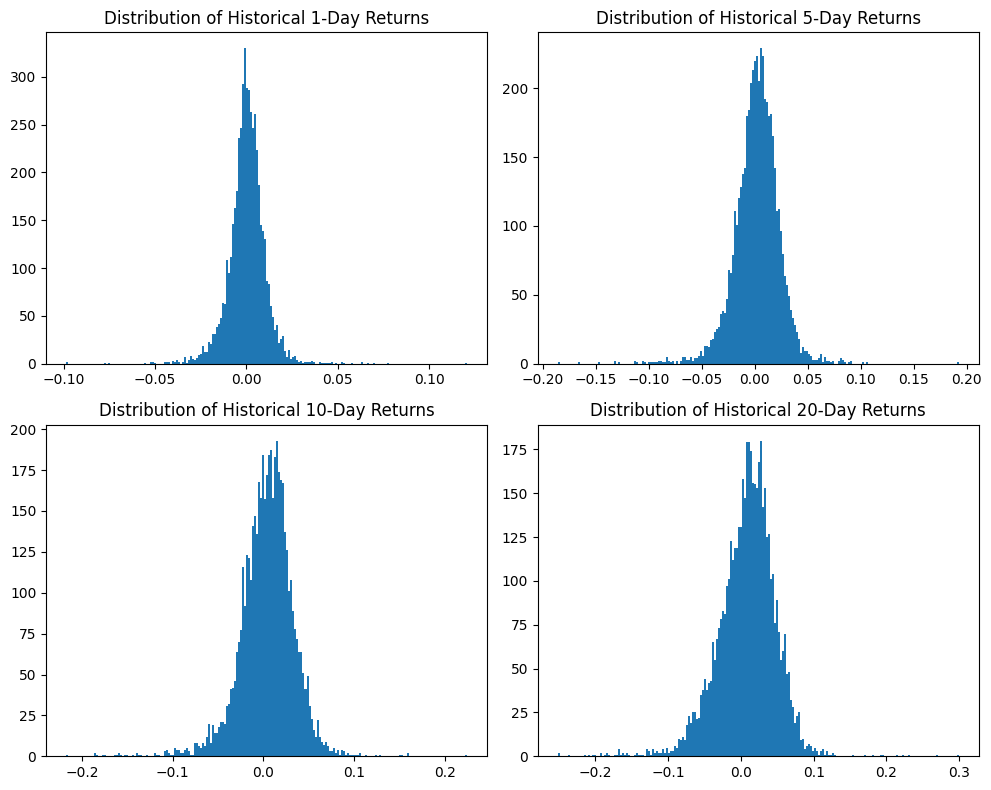

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

def plot_hist_returns(ax, data, col, title):
    ax.hist(data[col], bins=200)
    ax.set_title(title)

for i, window in enumerate(hist_ret_windows):
    plot_hist_returns(axs[i // 2, i % 2], data, f"ret_{window}d_hist", f"Distribution of Historical {window}-Day Returns")

plt.tight_layout()
plt.show()

In [12]:
# Create prediction target candidates for future 5-day return
data["tgt_ret_5d_fut"] = data["Adj Close"].shift(-5) / data["Adj Close"] - 1    # Future 5-day return
data["tgt_is_pos_ret_5d_fut"] = (data["tgt_ret_5d_fut"] > 0).astype(int)        # Future 5-day return is positive
data["tgt_is_gt10_ret_5d_fut"] = (data["tgt_ret_5d_fut"] > 0.1).astype(int)     # Future 5-day return is greater than 10%

In [13]:
# Pick one
target_col_name = "tgt_is_pos_ret_5d_fut"

In [14]:
# Inspect the distribution of the target variable
target_value_counts = data[target_col_name].value_counts()
target_value_counts / len(data)

tgt_is_pos_ret_5d_fut
1    0.566156
0    0.433844
Name: count, dtype: float64

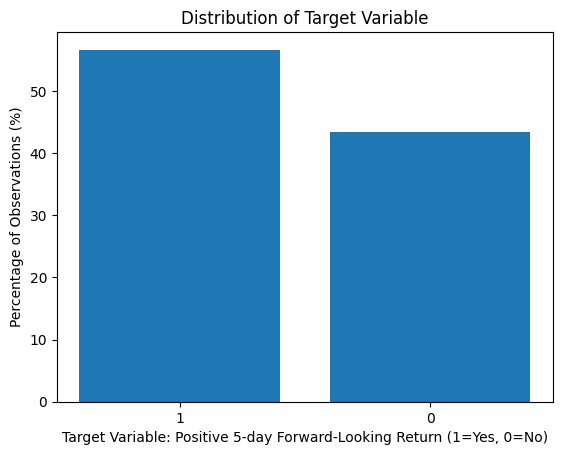

In [15]:
target_value_percentages = target_value_counts / len(data) * 100

plt.bar(target_value_percentages.index.astype(str), target_value_percentages.values)
plt.xlabel("Target Variable: Positive 5-day Forward-Looking Return (1=Yes, 0=No)")
plt.ylabel("Percentage of Observations (%)")
plt.title("Distribution of Target Variable")
plt.show()

The data looks relatively balanced in the distribution of the target variable.

Let's get data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/).


In [16]:
vix = yf.download("^VIX", start="2004-01-01", end="2024-03-31", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [17]:
vix.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-22,12.92,13.15,12.58,13.06,13.06,0
2024-03-25,13.67,13.67,13.11,13.19,13.19,0
2024-03-26,13.12,13.43,12.84,13.24,13.24,0
2024-03-27,13.13,13.34,12.66,12.78,12.78,0
2024-03-28,12.93,13.10,12.84,13.01,13.01,0


We should rename the column named "`Adj Close`" as it will clash with the one in our main DataFrame when we attempt to join them later.


In [18]:
vix.rename(columns={"Adj Close": "VIX Adj Close"}, inplace=True)

In [19]:
figure = px.line(
    vix,
    x=vix.index,
    y="VIX Adj Close",
    title="VIX Daily Adjusted Close Since 2004",
)
figure.show()

And load in Google Search Trends data for the term "recession" in the United States since 2004. This data is monthly.

> **Note from Google:** "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."


In [20]:
# load Google Trends Data, building the index (dates) from the "Month" column in the CSV (which is in "YYYY-MM" format), and setting the day to the last day of the month
google_trends = pd.read_csv("GoogleTrendsData.csv", index_col="Month", parse_dates=True)
google_trends.index = google_trends.index + pd.offsets.MonthEnd()
google_trends = google_trends.rename(columns={"recession: (United States)": "recession_search_trend"})

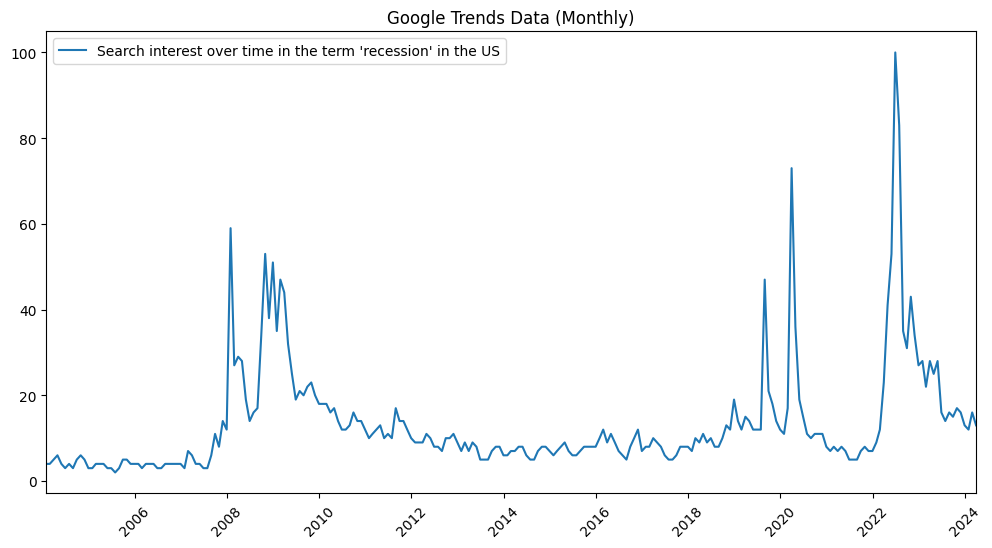

In [21]:
# Plot the Google Trends data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(google_trends)
date_fmt = mdates.DateFormatter("%Y-%m")
plt.xlim(google_trends.index[0], google_trends.index[-1])
plt.xticks(rotation=45)
plt.title("Google Trends Data (Monthly)")
plt.legend(["Search interest over time in the term 'recession' in the US"])
plt.show()

But not every month-end is a trading day. Also, what value should we use for all the days in between month-ends?

In [22]:
google_trends_daily = google_trends.resample('D').asfreq()
google_trends_daily = google_trends_daily.interpolate(method='linear')

The shape of the chart should not have changed...


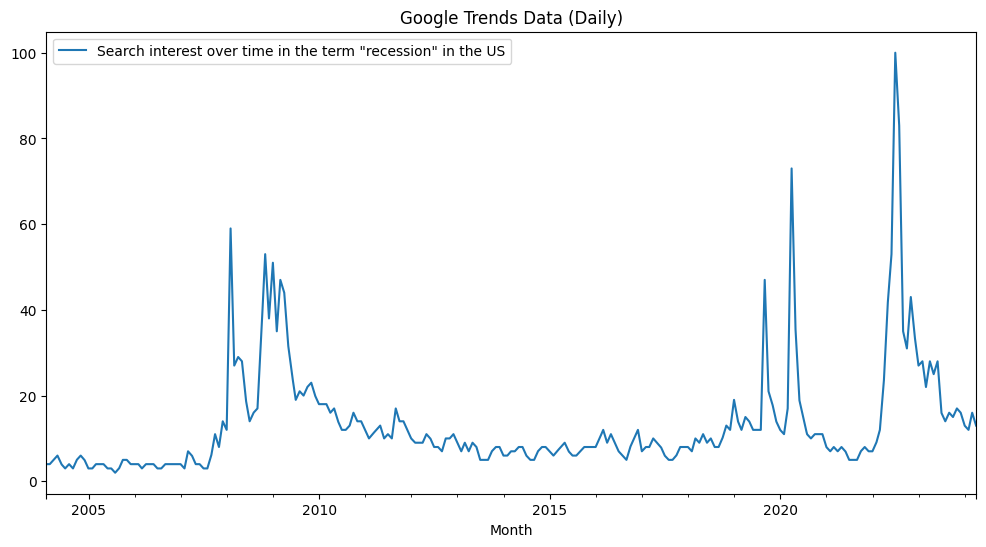

In [23]:
google_trends_daily.plot.line(title="Google Trends Data (Daily)", figsize=(12, 6)).legend(
    labels=['Search interest over time in the term "recession" in the US']
);

## 2. Feature Engineering and Analysis


### 2.1. Feature Engineering


In [24]:
# Engineer the first feature: "Internal Bar Strength" (IBS), a technical analysis indicator
data["IBS"] = (data["Close"] - data["Low"]) / (data["High"] - data["Low"])

In [25]:
# Get some more technical indicators using the `ta` library

indicator_bb = BollingerBands(close=data["Close"], window=20, window_dev=2)
indicator_rsi = RSIIndicator(close=data["Close"], window=14)

# Add Bollinger Bands features
data["bb_bbm"] = indicator_bb.bollinger_mavg()
data["bb_bbh"] = indicator_bb.bollinger_hband()
data["bb_bbl"] = indicator_bb.bollinger_lband()

# Add Bollinger Band high and low indicators
data["bb_bbhi"] = indicator_bb.bollinger_hband_indicator()
data["bb_bbli"] = indicator_bb.bollinger_lband_indicator()

# Add Width Size and Percentage Bollinger Bands
data["bb_bbw"] = indicator_bb.bollinger_wband()
data["bb_bbp"] = indicator_bb.bollinger_pband()

# Add RSI
data["rsi"] = indicator_rsi.rsi()

We could convert both the `Month` and the `Weekday` columns to "cyclical" or "categorical" features. The former would capture their cyclical nature while the latter would not. The choice is entirely up to us and depends on how important we believe this cyclicality is as a "feature". Here, we will treat `Month` as a cyclical feature because it will add two features instead of twelve. But we will treat `Weekday` as categorical and one-hot encode it to create five additional features.

In [26]:
# Treat `Month` as a "cyclical" feature.
data["Month_sin"] = np.sin(2 * np.pi * data["Month"] / 12)
data["Month_cos"] = np.cos(2 * np.pi * data["Month"] / 12)

data.drop(columns=["Month"], inplace=True)

# Treat `Weekday` as a "categorical" feature and one-hot-encode it.
data = pd.get_dummies(data, columns=["Weekday"], prefix="weekday", dtype="int32")

Let's replace trading volumes by their logarithms, as `Volume` currently spans several orders of magnitude and taking its logarithm helps emphasize variations in the lower range.  

**Note:** For tree-based models such as Decision Trees and Random Forests, scaling is not necessary. But feature scaling becomes critically important if we use other model types (e.g. distance-based models).

In [27]:
data["log_volume"] = np.log(data["Volume"])

We are done engineering new features and can now drop the original price and volume data.

In [28]:
data.drop(
    columns=["Open", "High", "Low", "Close", "Adj Close", "Volume"],
    inplace=True,
)

In [29]:
# Join the Google Trends data and technical indicators with the stock price data
data = data.join(google_trends_daily, how="left")
data = data.join(vix["VIX Adj Close"], how="left")

### 2.2. Further Data Preprocessing and Cleaning

Now we need to preprocess and clean the combined DataFrame.

In [30]:
data.isna().sum()

ret_1d_hist                1
ret_5d_hist                5
ret_10d_hist              10
ret_20d_hist              20
tgt_ret_5d_fut             5
tgt_is_pos_ret_5d_fut      0
tgt_is_gt10_ret_5d_fut     0
IBS                        0
bb_bbm                    19
bb_bbh                    19
bb_bbl                    19
bb_bbhi                    0
bb_bbli                    0
bb_bbw                    19
bb_bbp                    19
rsi                       13
Month_sin                  0
Month_cos                  0
weekday_0                  0
weekday_1                  0
weekday_2                  0
weekday_3                  0
weekday_4                  0
log_volume                 0
recession_search_trend    20
VIX Adj Close              0
dtype: int64

We know that some features, such as historical returns, RSI, Bollinger Bands and BB indicators cannot be calculated for the first `n` days due to their "rolling" nature. We can impute these features with reasonable estimates, or just drop them. We will do the latter. (Note: The largest `n` is `20`, corresponding to 20-day historical returns.)

In [31]:
data.drop(data.index[:20], inplace=True)

We do not have `recession_search_trend` data for the first month of data (January 2004) except on the last day of the month. But we know that the monthly values capture search trends over the duration of the entire month. So it would be very reasonable to backfill the entire month of January 2004 with the value from January 31st from the original monthly data. However, let us first check to see if there are any days remaining in January 2004 after dropping the first 20 rows in the previous step.

In [32]:
google_trends.loc["2004-01", "recession_search_trend"]

Month
2004-01-31    4
Name: recession_search_trend, dtype: int64

There is only one day in January and it is the very last day, for which we already have a value. Let us check for any remaining `NaN`s.

In [33]:
data.isna().sum()

ret_1d_hist               0
ret_5d_hist               0
ret_10d_hist              0
ret_20d_hist              0
tgt_ret_5d_fut            5
tgt_is_pos_ret_5d_fut     0
tgt_is_gt10_ret_5d_fut    0
IBS                       0
bb_bbm                    0
bb_bbh                    0
bb_bbl                    0
bb_bbhi                   0
bb_bbli                   0
bb_bbw                    0
bb_bbp                    0
rsi                       0
Month_sin                 0
Month_cos                 0
weekday_0                 0
weekday_1                 0
weekday_2                 0
weekday_3                 0
weekday_4                 0
log_volume                0
recession_search_trend    0
VIX Adj Close             0
dtype: int64

In [34]:
# Show the rows with missing values
data[data.isna().any(axis=1)]

,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,tgt_ret_5d_fut,tgt_is_pos_ret_5d_fut,tgt_is_gt10_ret_5d_fut,IBS,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,Month_sin,Month_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,log_volume,recession_search_trend,VIX Adj Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-22,-0.001373,0.004163,-0.003174,-0.012815,NaN,0,0,0.187507,145.979001,147.311830,144.646172,0.0,0.0,1.826056,0.297799,51.608138,1.0,6.123234e-17,0,0,0,0,1,15.527000,13.870968,13.06
2024-03-25,-0.001375,0.002900,-0.004001,-0.009079,NaN,0,0,0.270599,145.886001,147.150805,144.621197,0.0,0.0,1.733962,0.244626,50.296176,1.0,6.123234e-17,1,0,0,0,0,15.474310,13.580645,13.19
2024-03-26,0.003649,-0.000069,-0.004990,-0.003023,NaN,0,0,0.787503,145.837501,147.040475,144.634527,0.0,0.0,1.649746,0.471946,53.658283,1.0,6.123234e-17,0,1,0,0,0,15.753158,13.483871,13.24
2024-03-27,0.013309,0.015538,0.012177,0.015296,NaN,0,0,1.000000,145.922501,147.376307,144.468696,1.0,0.0,1.992572,1.114768,63.413817,1.0,6.123234e-17,0,0,1,0,0,15.989967,13.387097,12.78
2024-03-28,0.000135,0.014350,0.015921,0.023777,NaN,0,0,0.090914,146.068001,147.629788,144.506214,1.0,0.0,2.138438,1.032081,63.499079,1.0,6.123234e-17,0,0,0,1,0,15.906164,13.290323,13.01


The last few rows of data have `NaN`s due to the calculation of rolling "future" returns for our target variable. We need to `drop()` these.


In [35]:
data.dropna(inplace=True)

Let us perform a final check for `NaN`s and take a look at the characteristics of the set of features and targets.

In [36]:
data.isna().sum().sum()

0

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5069 entries, 2004-02-02 to 2024-03-21
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ret_1d_hist             5069 non-null   float64
 1   ret_5d_hist             5069 non-null   float64
 2   ret_10d_hist            5069 non-null   float64
 3   ret_20d_hist            5069 non-null   float64
 4   tgt_ret_5d_fut          5069 non-null   float64
 5   tgt_is_pos_ret_5d_fut   5069 non-null   int64  
 6   tgt_is_gt10_ret_5d_fut  5069 non-null   int64  
 7   IBS                     5069 non-null   float64
 8   bb_bbm                  5069 non-null   float64
 9   bb_bbh                  5069 non-null   float64
 10  bb_bbl                  5069 non-null   float64
 11  bb_bbhi                 5069 non-null   float64
 12  bb_bbli                 5069 non-null   float64
 13  bb_bbw                  5069 non-null   float64
 14  bb_bbp                

In [38]:
data.describe()

,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,tgt_ret_5d_fut,tgt_is_pos_ret_5d_fut,tgt_is_gt10_ret_5d_fut,IBS,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,Month_sin,Month_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,log_volume,recession_search_trend,VIX Adj Close
count,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5.069000e+03,5.069000e+03,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000
mean,0.000427,0.002097,0.004185,0.008346,0.002085,0.565989,0.000592,0.534112,65.190507,67.147802,63.233213,0.060761,0.054054,5.948065,0.567198,53.683015,-2.838770e-03,-7.572043e-03,0.186625,0.205169,0.205761,0.202210,0.200237,15.409240,13.290878,19.099797
std,0.010493,0.021729,0.029813,0.040486,0.021722,0.495675,0.024323,0.307988,36.490915,37.643799,35.382734,0.238916,0.226147,3.644471,0.326476,11.253373,7.097124e-01,7.045852e-01,0.389648,0.403865,0.404296,0.401687,0.400217,1.081947,12.478947,8.747777
min,-0.098610,-0.185835,-0.217250,-0.251548,-0.185835,0.000000,0.000000,0.000000,23.217500,24.569328,20.419952,0.000000,0.000000,1.165471,-0.452267,13.539141,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,10.980195,2.032258,9.140000
25%,-0.004458,-0.009204,-0.011609,-0.013454,-0.009204,0.000000,0.000000,0.259258,32.040500,32.789038,31.152674,0.000000,0.000000,3.790178,0.310053,46.019133,-8.660254e-01,-8.660254e-01,0.000000,0.000000,0.000000,0.000000,0.000000,15.158428,6.322581,13.380000
50%,0.000633,0.002930,0.005917,0.011536,0.002917,1.000000,0.000000,0.546873,57.274000,58.749715,54.721044,0.000000,0.000000,5.052307,0.622857,54.080883,-2.449294e-16,-1.836970e-16,0.000000,0.000000,0.000000,0.000000,0.000000,15.703898,9.225806,16.549999
75%,0.005891,0.014858,0.021954,0.032931,0.014827,1.000000,0.000000,0.818179,90.399500,93.205837,87.412764,0.000000,0.000000,7.015371,0.832430,61.812445,8.660254e-01,5.000000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,16.075052,14.931034,22.129999
max,0.120547,0.192308,0.223935,0.299116,0.192308,1.000000,1.000000,1.000000,146.183501,148.369194,144.631724,1.000000,1.000000,32.354816,1.349959,85.413254,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,18.012264,100.000000,82.690002


### 2.3. Correlation Analysis


Correlation analysis can be a form of approximate and early feature importance analysis. Features that are highly correlated with each other (but not with the target variable) can be a sign of multicollinearity problems, which means they might not add much additional information in predicting the target. Looking at the correlation matrix heatmap can be helpful in identifying such features.


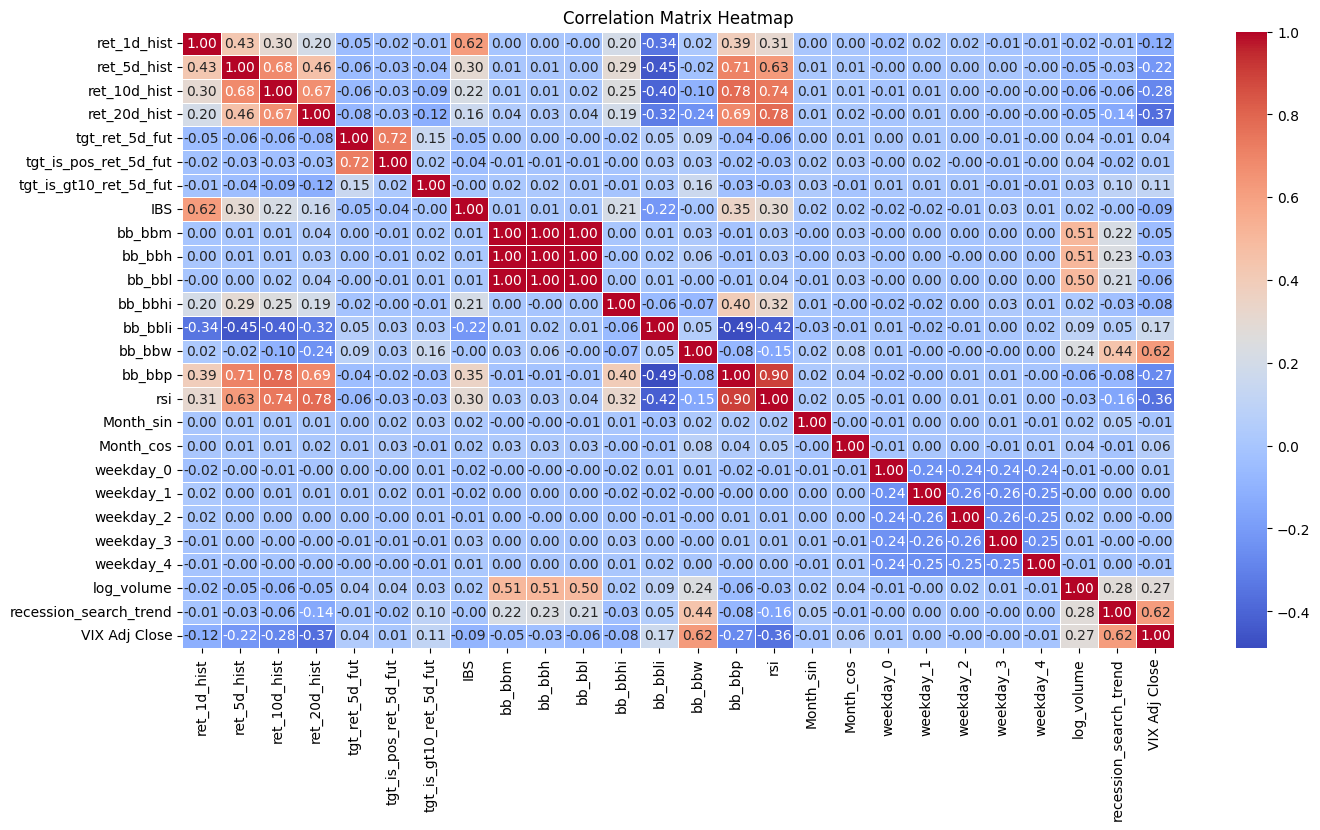

In [39]:
def plot_corr_mtx(data: pd.DataFrame):
    plt.figure(figsize=(16, 8))
    sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

plot_corr_mtx(data)

In [40]:
# Drop bb_bbh and bb_bbl due to their high correlation with bb_bbm
data.drop(columns=["bb_bbh", "bb_bbl"], inplace=True)

# Also drop Bollinger Band Percentage (bb_bbp) due to its high correlation with RSI
data.drop(columns=["bb_bbp"], inplace=True)

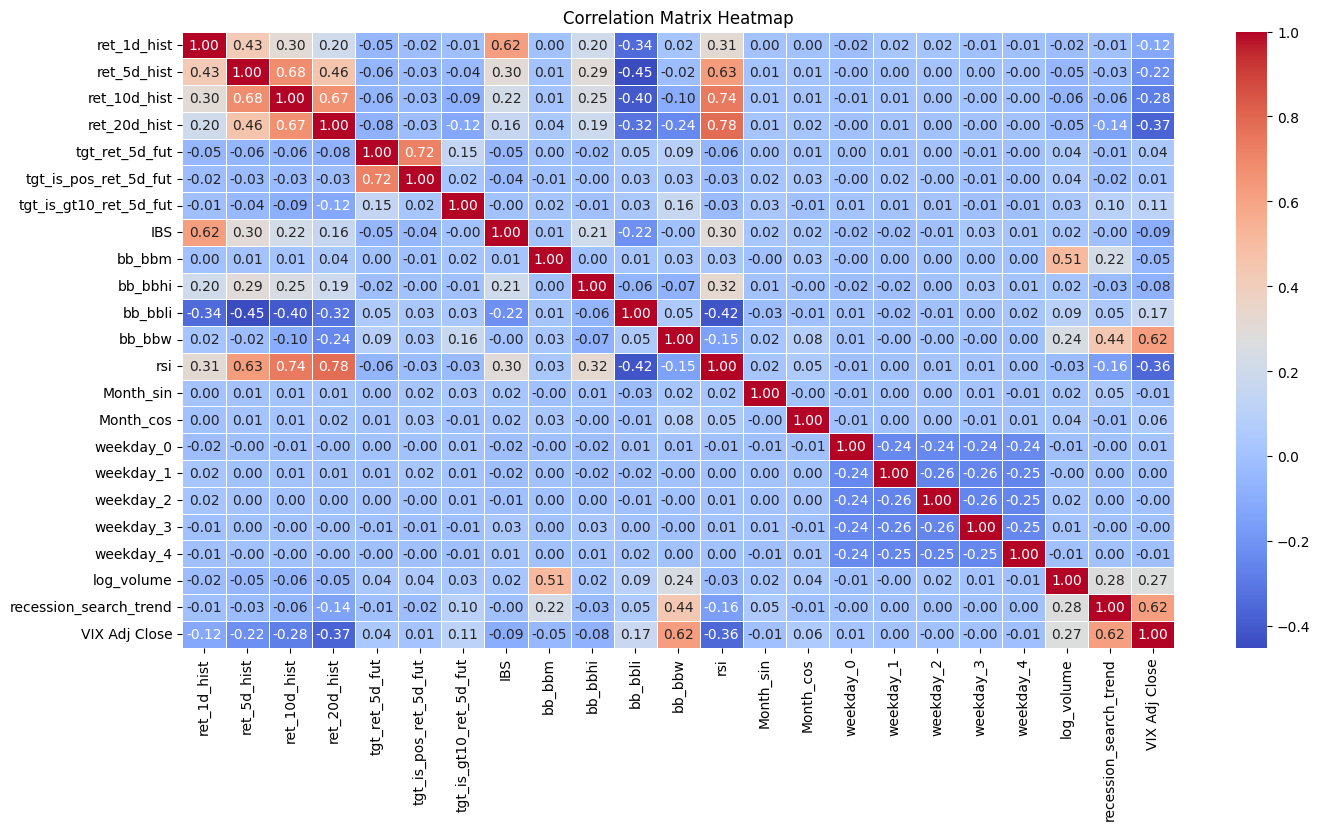

In [41]:
plot_corr_mtx(data)

Features that are highly correlated (negatively or positively) with the target variable are likely more important. Which variables are correlated more than 4% (in either direction) with the boolean target variable denoting whether 5-day future returns are positive?


In [42]:
data.corr()[target_col_name].abs().sort_values(ascending=False)

tgt_is_pos_ret_5d_fut     1.000000
tgt_ret_5d_fut            0.722078
IBS                       0.044293
log_volume                0.043164
Month_cos                 0.034075
ret_10d_hist              0.032284
bb_bbw                    0.031639
ret_5d_hist               0.031627
bb_bbli                   0.031542
rsi                       0.026672
ret_20d_hist              0.025091
ret_1d_hist               0.022092
tgt_is_gt10_ret_5d_fut    0.021310
recession_search_trend    0.021242
weekday_1                 0.020079
Month_sin                 0.016087
weekday_3                 0.014012
bb_bbm                    0.009908
VIX Adj Close             0.009806
weekday_4                 0.004455
bb_bbhi                   0.002207
weekday_2                 0.001306
weekday_0                 0.000435
Name: tgt_is_pos_ret_5d_fut, dtype: float64

## 3. The Training-Validation-Testing Split

### 3.1. The Split

It is time to split our data, temporally, into the train + validation and test sets. We will train and optimize (cross-validate) our model on the first 75% of the data, and use the remaining 25% for the test set (to evaluate the performance of the model).  

**Note:** Technically, we can shuffle the data, as we are not using statistical time-series prediction methods (such as ARIMA). But for ease of interpretability and backtesting, we may as well keep the data ordered, as long as the distributions of features and the target do not change over time. - And that is a big assumption! (Hint: Drift analysis)

In [43]:
def split(df, min_date, max_date, train_val_prop, test_prop):
    assert train_val_prop + test_prop == 1, "Proportions must add up to 1"

    df = df.sort_index()
    df = df[(df.index >= min_date) & (df.index <= max_date)]

    split_point = int(len(df) * train_val_prop)
    df["split"] = "test"
    df.iloc[:split_point, df.columns.get_loc("split")] = "train_val"

    return df

In [44]:
TRAIN_VAL_PROP = 0.75
TEST_PROP = 1 - (TRAIN_VAL_PROP)

data_w_splits = split(
    data,
    min_date=data.index.min(),
    max_date=data.index.max(),
    train_val_prop=TRAIN_VAL_PROP,
    test_prop=TEST_PROP,
)

A quick sanity check:

In [45]:
data_w_splits.split.value_counts()

split
train_val    3801
test         1268
Name: count, dtype: int64

In [46]:
data_w_splits.split.value_counts() / len(data_w_splits)

split
train_val    0.749852
test         0.250148
Name: count, dtype: float64

It is the 75%-25% we are aiming for. Now we create a master list of features (independent variables) and prediction targets (dependent variables) and perform the split.


In [47]:
features = data_w_splits.drop(data.filter(regex="^tgt_").columns, axis=1, inplace=False)
targets = data_w_splits.filter(regex="^tgt_", axis=1).join(data_w_splits["split"])

# X = features.drop(columns=["split"], inplace=False)
# y = targets[target_col_name]
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

X_train_val = features[features.split == "train_val"].drop(columns=["split"], inplace=False)
X_test = features[features.split == "test"].drop(columns=["split"], inplace=False)

y_train_val = targets[targets.split == "train_val"][target_col_name]
y_test = targets[targets.split == "test"][target_col_name]

### 3.2. Baseline Model and Score

Let's take a look at the distribution of the target variable in each set and come up with a baseline score.

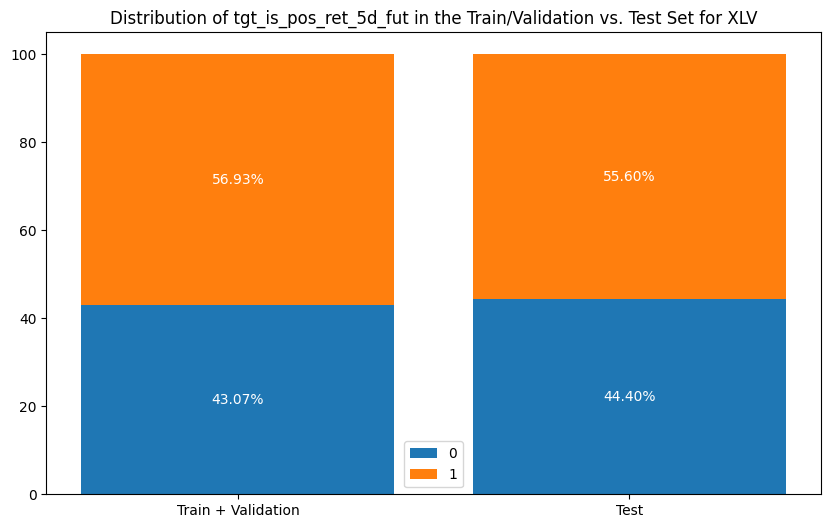

In [48]:
train_val_counts = y_train_val.value_counts(normalize=True) * 100
test_counts = y_test.value_counts(normalize=True) * 100

categories = ["Train + Validation", "Test"]
zero_counts = [train_val_counts[0], test_counts[0]]
one_counts = [train_val_counts[1], test_counts[1]]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(categories, zero_counts, label="0")
ax.bar(categories, one_counts, bottom=zero_counts, label="1")

# Add text annotations
for i, (zero, one) in enumerate(zip(zero_counts, one_counts)):
    ax.text(i, zero / 2, f"{zero:.2f}%", ha="center", va="center", color="white")
    ax.text(
        i,
        zero + one / 2,
        f"{one:.2f}%",
        ha="center",
        va="center",
        color="white",
    )
ax.set_title(f"Distribution of {target_col_name} in the Train/Validation vs. Test Set for XLV")
ax.legend()

plt.show()

If we were to naively always predict the majority class (in this case `1`), we would be correct 56.93% of the time on the training/validation set and 55.6% of the time on the testing set. This provides a baseline score for us to try to beat.

## 4. Model Training and Tuning


Inspect the learning curves for a RandomForestClassifier with a max_depth of 10, using 10%, 20%, 30%,... , and 100% of the training data, with 5-fold cross-validation.


In [49]:
train_sizes = np.linspace(0.1, 1.0, 10)
max_depth = 10
model = RandomForestClassifier(max_depth=max_depth, random_state=42, n_jobs=-1)

In [50]:
def plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axs.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="b",
    )
    axs.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="r",
    )
    axs.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="b",
        label="Average Score on Training Sets",
    )
    axs.plot(
        train_sizes,
        test_scores_mean,
        "o-",
        color="r",
        label="Average Score on Test Sets",
    )
    axs.set_xlabel("Training examples")
    axs.set_ylabel("Score")
    axs.set_title(f"Learning Curves (max_depth={max_depth})")
    axs.legend(loc="center left")
    axs.grid(True)

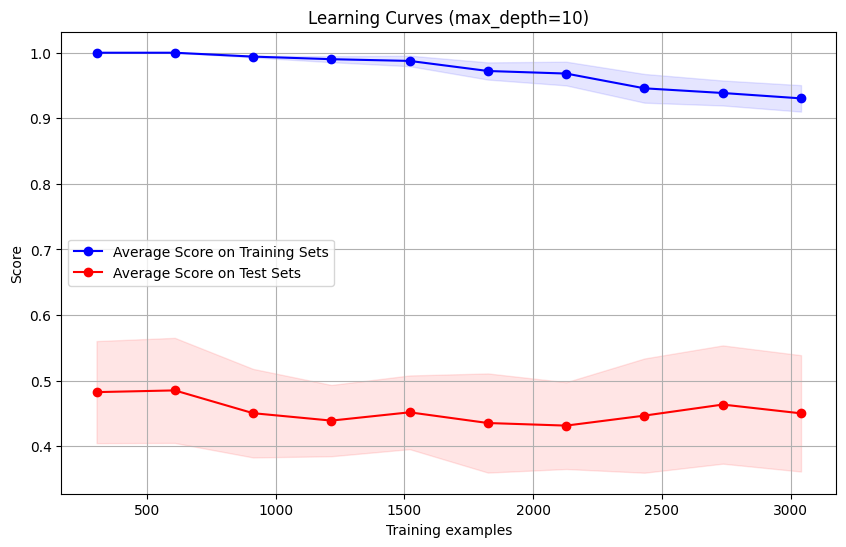

In [51]:
figure = plt.figure(figsize=(10, 6))
axs = figure.gca()

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
)

plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs)

plt.show()

We observe overfitting. How do we address this? Experiment with lower and higher values for `max_depth` to see how the plots change.


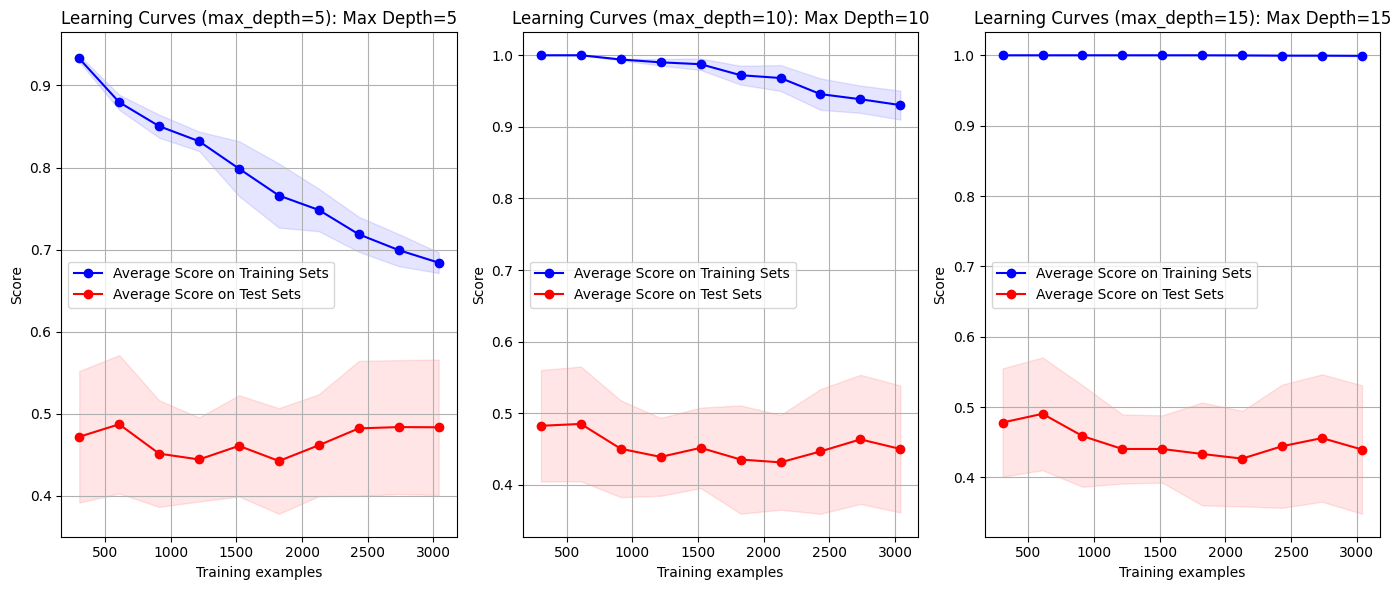

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
max_depth_range = [5, 10, 15]
for i, max_depth in enumerate(max_depth_range):
    model = RandomForestClassifier(max_depth=max_depth, random_state=42, n_jobs=-1)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
    )
    plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs[i])
    axs[i].set_title(axs[i].title.get_text() + f": Max Depth={max_depth}")

plt.tight_layout()
plt.show()

There are other hyperparameters as well, such as `min_samples_split` (default=2), `min_samples_leaf` (default=1) and `n_estimators` (default=100).
Let's use GridSearch to find the optimal combination from the list below:


In [53]:
grid = {
    "max_depth": range(2, 6),
    # "min_samples_split": range(2, 6),
    "min_samples_leaf": range(1, 5),
    "n_estimators": [50, 75, 100, 125, 150],
}

search = GridSearchCV(model, grid, scoring="accuracy", cv=5, n_jobs=-1)

search.fit(X_train_val, y_train_val);

In [54]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.274940,0.032652,0.050233,0.012700,2,1,150,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.461235,0.371053,0.569737,0.569737,0.568421,0.508037,0.080268,1
9,0.336322,0.049584,0.047086,0.011679,2,2,150,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.461235,0.371053,0.569737,0.569737,0.568421,0.508037,0.080268,1
14,0.342500,0.124823,0.041706,0.012321,2,3,150,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.461235,0.371053,0.569737,0.569737,0.568421,0.508037,0.080268,1
2,0.201093,0.025652,0.052481,0.029466,2,1,100,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.463863,0.368421,0.569737,0.569737,0.568421,0.508036,0.080875,4
7,0.188473,0.016693,0.081450,0.049695,2,2,100,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.463863,0.368421,0.569737,0.569737,0.568421,0.508036,0.080875,4
12,0.254932,0.024592,0.063774,0.033040,2,3,100,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.463863,0.368421,0.569737,0.569737,0.568421,0.508036,0.080875,4
17,0.235831,0.029651,0.040239,0.015434,2,4,100,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.462549,0.368421,0.569737,0.569737,0.568421,0.507773,0.081020,7
19,0.368125,0.073205,0.059810,0.031436,2,4,150,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.458607,0.371053,0.569737,0.569737,0.568421,0.507511,0.080581,8
18,0.246051,0.036621,0.054824,0.009309,2,4,125,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.462549,0.365789,0.569737,0.569737,0.568421,0.507247,0.081927,9
3,0.257896,0.018882,0.042853,0.016947,2,1,125,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.459921,0.365789,0.569737,0.569737,0.568421,0.506721,0.082220,10


Looking at the results of GridSearch, which parameters yield the highest scores? And which parameters do not seem to have any effect on the score?

<details>
<summary>Show Answers</summary>

The best combination is `max_depth=2`, `min_samples_leaf=1` and `n_estimators=100` and for it makes no difference which `min_samples_split` value we choose to go along with these.

</details>


In [55]:
search.best_params_

{'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 150}

## 5. Model Evaluation and Interpretation


### 5.1. Evaluation (Performance Metrics)

It is time to train our model on the training data with the optimal set of hyperparameters we have found, and evaluate its performance on the test set.


In [56]:
clf = RandomForestClassifier(max_depth=2, min_samples_leaf=1, n_estimators=150, random_state=42, n_jobs=-1)
clf.fit(X_train_val, y_train_val)
clf.score(X_test, y_test)

0.555993690851735

In [57]:
y_test_pred = clf.predict(X_test)
evaluation = {
    "accuracy" : accuracy_score(y_test, y_test_pred),
    "precision" : precision_score(y_test, y_test_pred),
    "recall" : recall_score(y_test, y_test_pred),
    "f1" : f1_score(y_test, y_test_pred)
}
display(evaluation)

{'accuracy': 0.555993690851735,
 'precision': 0.555993690851735,
 'recall': 1.0,
 'f1': 0.7146477445514445}

What do the precision and recall scores mean?
<details>
<summary>Show Answers</summary>

The Precision Score tells us that 55.6% of the predicted positives were true positives and the remaining 44.4% were false positives.  
The Recall Score shows that 100% of all actual positives were predicted (i.e. there were no false negatives).

</details>

In [58]:
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       563
           1       0.56      1.00      0.71       705

    accuracy                           0.56      1268
   macro avg       0.28      0.50      0.36      1268
weighted avg       0.31      0.56      0.40      1268



In [59]:
confusion_matrix(y_test, y_test_pred)

array([[  0, 563],
       [  0, 705]])

The model predicted negative returns only 3 times and has a recall score of _zero_! Is it "overfitting" to the training data?

In [60]:
y_train_val_pred = clf.predict(X_train_val)
print(classification_report(y_train_val, y_train_val_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1637
           1       0.57      1.00      0.73      2164

    accuracy                           0.57      3801
   macro avg       0.28      0.50      0.36      3801
weighted avg       0.32      0.57      0.41      3801



In [61]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[   0, 1637],
       [   0, 2164]])

No! It is not learning anything from the training data (i.e. underfitting). In fact, it is no better than our naive baseline "model".

### 5.2. Revisiting Feature Importance

Now that we have a fully trained, optimized and evaluated model, we can revisit feature importance. Are there any features that are not contributing significantly to the performance of the model?

In [62]:
feat_imp = pd.Series(clf.feature_importances_, index=X_train_val.columns)
display(feat_imp.sort_values(ascending=False))

bb_bbm                    0.183237
recession_search_trend    0.150532
IBS                       0.095349
log_volume                0.086274
ret_5d_hist               0.073007
rsi                       0.064090
ret_10d_hist              0.058342
VIX Adj Close             0.057133
Month_cos                 0.056717
bb_bbw                    0.053365
ret_1d_hist               0.047575
ret_20d_hist              0.043327
Month_sin                 0.022676
weekday_1                 0.004743
weekday_2                 0.001457
weekday_4                 0.001210
bb_bbli                   0.000713
bb_bbhi                   0.000256
weekday_0                 0.000000
weekday_3                 0.000000
dtype: float64

Let's drop features that have an importance of 1% or less...

In [67]:
# Let's drop features that have an importance of 1% or less...
feat_to_drop = feat_imp[feat_imp <= 0.01].index
X_train_val_reduced = X_train_val.drop(columns=feat_to_drop, inplace=False)
X_test_reduced = X_test.drop(columns=feat_to_drop, inplace=False)

In [73]:
search = GridSearchCV(model, grid, scoring="accuracy", cv=5, n_jobs=-1)

search.fit(X_train_val_reduced, y_train_val);

In [74]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.122534,0.008190,0.050608,0.021398,2,4,50,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.455979,0.382895,0.569737,0.569737,0.568421,0.509354,0.076970,1
10,0.115225,0.019020,0.054580,0.038352,2,3,50,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.455979,0.381579,0.569737,0.569737,0.568421,0.509091,0.077403,2
0,0.134151,0.016622,0.026968,0.015116,2,1,50,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.455979,0.380263,0.569737,0.569737,0.568421,0.508827,0.077837,3
5,0.171399,0.038339,0.067153,0.006996,2,2,50,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.455979,0.380263,0.569737,0.569737,0.568421,0.508827,0.077837,3
3,0.295862,0.027040,0.031118,0.008966,2,1,125,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.457293,0.375000,0.569737,0.569737,0.568421,0.508038,0.079415,5
8,0.361019,0.037946,0.057458,0.027514,2,2,125,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.457293,0.375000,0.569737,0.569737,0.568421,0.508038,0.079415,5
13,0.299290,0.037333,0.048930,0.017867,2,3,125,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.457293,0.373684,0.569737,0.569737,0.568421,0.507774,0.079856,7
7,0.324770,0.068801,0.035988,0.011766,2,2,100,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.455979,0.371053,0.569737,0.569737,0.568421,0.506985,0.080906,8
2,0.262856,0.011910,0.043726,0.018858,2,1,100,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.455979,0.371053,0.569737,0.569737,0.568421,0.506985,0.080906,8
12,0.239909,0.032478,0.093729,0.009251,2,3,100,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.455979,0.371053,0.569737,0.569737,0.568421,0.506985,0.080906,8


In [75]:
search.best_params_

{'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 50}

In [76]:
clf = RandomForestClassifier(max_depth=2, min_samples_leaf=4, n_estimators=50, random_state=42, n_jobs=-1)
clf.fit(X_train_val_reduced, y_train_val)
clf.score(X_test_reduced, y_test)

0.557570977917981

In [79]:
y_test_pred = clf.predict(X_test_reduced)
evaluation = {
    "accuracy" : accuracy_score(y_test, y_test_pred),
    "precision" : precision_score(y_test, y_test_pred),
    "recall" : recall_score(y_test, y_test_pred),
    "f1" : f1_score(y_test, y_test_pred)
}
display(evaluation)

{'accuracy': 0.557570977917981,
 'precision': 0.5573248407643312,
 'recall': 0.9929078014184397,
 'f1': 0.7139214686384497}

In [80]:
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.58      0.01      0.02       563
           1       0.56      0.99      0.71       705

    accuracy                           0.56      1268
   macro avg       0.57      0.50      0.37      1268
weighted avg       0.57      0.56      0.41      1268



In [81]:
confusion_matrix(y_test, y_test_pred)

array([[  7, 556],
       [  5, 700]])

In [82]:
y_train_val_pred = clf.predict(X_train_val_reduced)
print(classification_report(y_train_val, y_train_val_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.83      0.01      0.01      1637
           1       0.57      1.00      0.73      2164

    accuracy                           0.57      3801
   macro avg       0.70      0.50      0.37      3801
weighted avg       0.68      0.57      0.42      3801



In [83]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[  10, 1627],
       [   2, 2162]])

In [77]:
pd.Series(clf.feature_importances_, index=X_train_val_reduced.columns)

ret_1d_hist               0.041481
ret_5d_hist               0.056719
ret_10d_hist              0.044508
ret_20d_hist              0.019764
IBS                       0.104045
bb_bbm                    0.123318
bb_bbw                    0.066519
rsi                       0.068810
Month_sin                 0.039833
Month_cos                 0.051730
log_volume                0.157171
recession_search_trend    0.172432
VIX Adj Close             0.053669
dtype: float64

In [63]:
# figure = plt.figure(figsize=(10, 6))
# axs = figure.gca()

# train_sizes, train_scores, test_scores = learning_curve(
#     clf, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
# )

# plot_learning_curves(train_sizes, train_scores, test_scores, search.best_params_["max_depth"], axs)

# plt.show()

In [64]:
# from tpot import TPOTClassifier

# tpot = TPOTClassifier(verbosity=2, scoring='accuracy', n_jobs=-1, cv=5)

# tpot.fit(X_train_val, y_train_val)

# print(tpot.score(X_test, y_test))

In [65]:
# import os
# tpot.export(os.path.join(os.getcwd(),'tpot_pipeline.py'))